# Classification Aware Lloyd-max Quantization

In [1]:
import jax.numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
import seaborn as sns

from joblib import Parallel, delayed
from IPython.display import Markdown
from numpy.random import seed as set_seed
from itertools import product

sns.set(style="darkgrid")
CPU_COUNT = multiprocessing.cpu_count()
parallel = Parallel(n_jobs=CPU_COUNT, verbose=3)

In [2]:
def classify(S):
    return 2*(S[:, 0, :] > S[:, 1, :])-1

def make_unit_vector(v):
    arr = np.array(v)
    return arr/np.sqrt(arr@arr)

def normalize(X):
    x = X - X.min(axis=0)
    return x/x.max(axis=0)

def reconstruction_loss(S, X) -> '(N, 2**R)':
    return ((S - X)**2).sum(axis=1)

def classification_loss(S, X) -> '(N, 2**R)':
    return classify(S) != classify(X)

def calc_total_loss(losses, γ):
    return losses @ np.array([1-γ, γ])

def codeword_losses(S, X) -> '(N, 2**R, 2)':
    return np.stack([reconstruction_loss(S, X),
                     classification_loss(S, X)], axis=-1)

def calc_optimal_Qinv_given_X(S, X, γ) -> 'Qinv: (N,); losses: (2,)':
    losses: '(N, 2**R, 2)' = codeword_losses(S, X)
    loss_total = calc_total_loss(losses, γ)
    Qinv: '(N,)' = loss_total.argmin(axis=1)
    return Qinv, losses[np.arange(S.shape[0]), Qinv].mean(axis=0)

def calc_optimal_X_given_Qinv(S, Qinv, w, γ, R) -> '(N, d, 2**R)':
    X_recon_opt = np.array([S[Qinv==i].mean(axis=0)
                           for i in range(2**R)
                           if (Qinv==i).sum() > 0]).T
#     Δ = - (w @ X_recon_opt)*w[:, np.newaxis]*(1 + 1e-5)
    return X_recon_opt #+ Δ*(False)

def lloyd_max_algorithm(S, X, w, γ, R, max_iter=200):
    losses = max_iter*[0]
    for i in range(max_iter):
        Qinv, losses[i] = calc_optimal_Qinv_given_X(S, X, γ)
        X = calc_optimal_X_given_Qinv(S, Qinv, w, γ, R)
    return np.array(losses), X, Qinv

def plot(S, X, Qinv, w, title):
    wrong = (classify(S) != classify(X[:, :, Qinv]).T).ravel()
    plt.scatter(*S.T[0], c=Qinv, alpha=0.8, cmap='Dark2')
    plt.scatter(*S[wrong].T[0], c='cyan', alpha=1)
    plt.scatter(*X[0], marker='X', c='black', s=100)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.axis('off')    

All vectors and matrices are created with 3 dimensions: 
sample points, data dimension and number of reconstruction points

/home/dsevero/miniconda3/envs/dsevero.com/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')



$N=2000, d=2, R=3, \gamma=0.01$

Lowest reconstruction (MSE) loss: 0.01807 @ iter=28

Lowest classification (0-1) loss: 0.06050 @ iter=32

Lowest total (MSE + 0-1) loss: 0.07860 @ iter=32



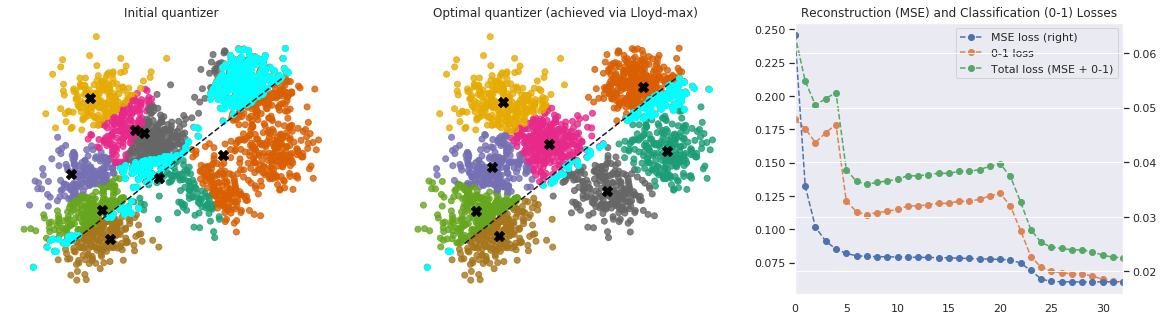

In [3]:
seed: 'global numpy seed' = 1
set_seed(seed)

w: 'unit vector normal to decision boundary' = make_unit_vector([-1, 1])
N: 'number of datapoints' = 2000
d: 'data dimension' = 2
R: 'rate (i.e. number of bits)' = 3
X: 'reconstruction points' = stats.uniform().rvs(size=(1, d, 2**R))
S: 'sample' = (stats.multivariate_normal(mean=stats.uniform().rvs(10*d),
                                         cov=1e-2)
                    .rvs(size=int(N/10))
                    .reshape(-1, 2)
                    [:, :, np.newaxis])
γ: 'classifiction (1) and reconstruction (0) trade-off' = 1e-2
losses: 'MSE and 0-1 losses for given X and Qinv'
Qinv: 'assigns a region to each datapoint'

assert S.shape == (N, d, 1)
assert X.shape == (1, d, 2**R)
assert γ >= 0 and γ <= 1

γ_vec = np.array([1-γ, γ])
losses, X_opt, Qinv_opt = lloyd_max_algorithm(S, X, w, γ, R, max_iter=200)

if d == 2:
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    Qinv, _ = calc_optimal_Qinv_given_X(S, X, γ)
    plot(S, X, Qinv, w, 'Initial quantizer')

    plt.subplot(1,3,2)
    plot(S, X_opt, Qinv_opt, w, 'Optimal quantizer (achieved via Lloyd-max)')

(pd.DataFrame(losses, columns=['MSE loss', '0-1 loss'])
   .assign(**{'Total loss (MSE + 0-1)': losses.sum(axis=1)})
   .plot(ax=plt.subplot(1,3,3) if d == 2 else None,
         secondary_y='MSE loss',
         title='Reconstruction (MSE) and Classification (0-1) Losses',
         xlim=(0, losses.argmin(axis=0).max()),
         style='o--'));

Markdown(f'''
$N={N}, d={d}, R={R}, \gamma={γ}$\n
Lowest reconstruction (MSE) loss: {losses.T[0].min():.5f} @ iter={losses.T[0].argmin()}\n
Lowest classification (0-1) loss: {losses.T[1].min():.5f} @ iter={losses.T[1].argmin()}\n
Lowest total (MSE + 0-1) loss: {losses.sum(axis=1).min():.5f} @ iter={losses.sum(axis=1).argmin()}\n
''')

In [4]:
try:
    metrics = pd.read_parquet('metrics.parq')
except:
    def single_run(R, d, γ, N, w):
        try:
            γ_vec = np.array([1 - γ, γ])
            X = stats.uniform().rvs(size=(1, d, 2**R))
            S = normalize(stats.norm().rvs(size=(N, d, 1)))
            losses, _, _= lloyd_max_algorithm(S, X, w, γ, R, max_iter=300)
            i = (losses @ γ_vec).argmin()
            loss_total = (losses @ γ_vec)[i]
            loss_recon, loss_class = losses[i]
        except:
            min_total_loss = min_recon_loss = min_class_loss = np.nan
        return {'loss_total': loss_total.item(),
                'loss_recon': loss_recon.item(),
                'loss_class': loss_class.item(),
                'R': R,
                'd': d,
                'γ': γ}

    search_space = product([2, 3, 4, 5],           # R
                           [5, 10, 20, 30],        # d
                           np.logspace(-5, 0, 30)) # γ

    metrics = (pd.DataFrame(parallel(delayed(single_run)(R, d, γ, N, w) 
                                     for R, d, γ in search_space))
                 .melt(value_vars=['loss_total', 
                                   'loss_recon', 
                                   'loss_class'],
                       var_name='loss_type',
                       value_name='loss_value',
                       id_vars=['R', 'd', 'γ']))
    metrics.to_parquet('metrics.parq')

metrics.head()

,R,d,γ,loss_type,loss_value
0,2,5,0.000010,loss_total,0.079242
1,2,5,0.000015,loss_total,0.074647
2,2,5,0.000022,loss_total,0.073847
3,2,5,0.000033,loss_total,0.080600
4,2,5,0.000049,loss_total,0.082409


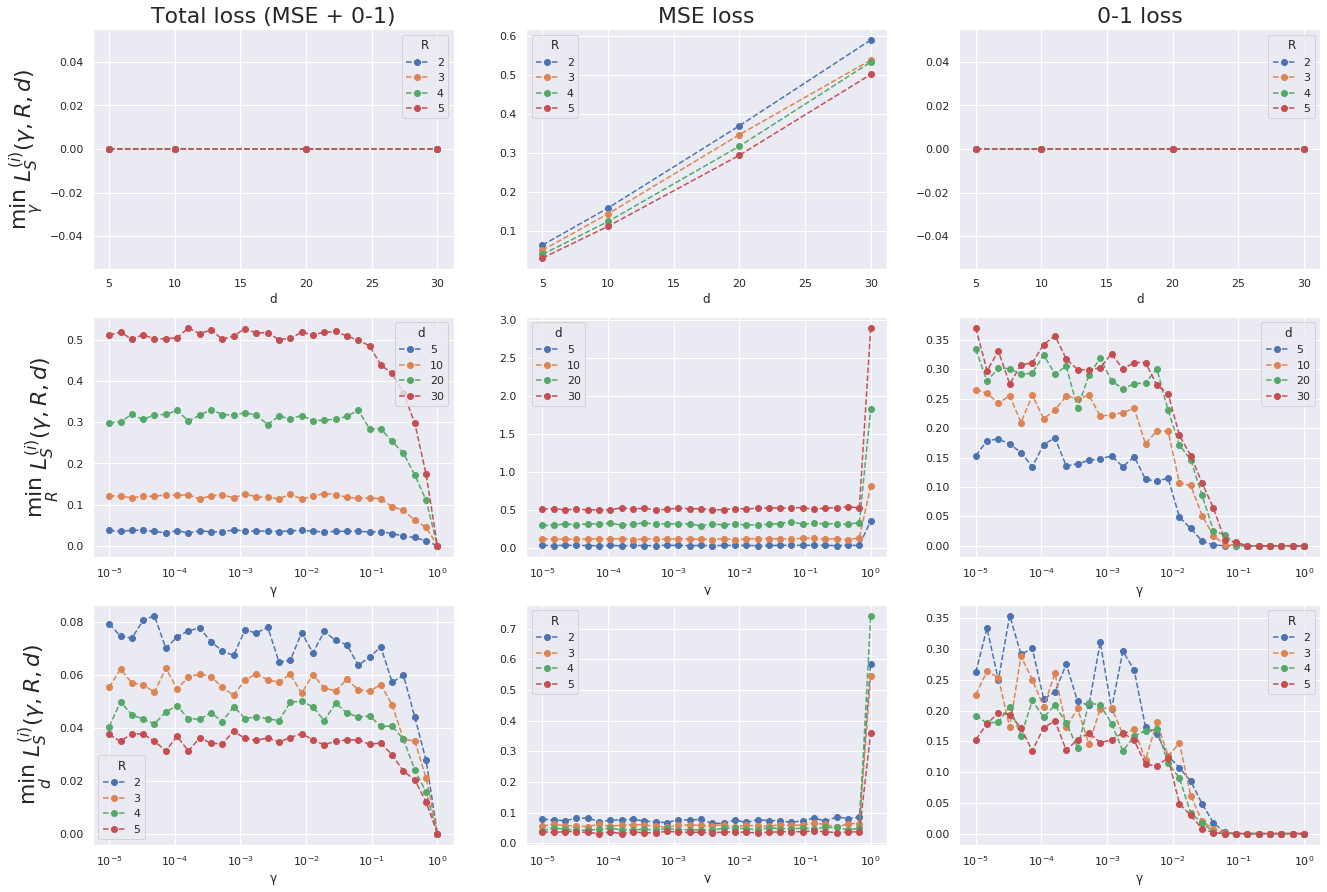


$L_S^{(i)}$ is the loss on sample $S$ at iteration $i$ which achieves the lowest Total loss.


In [5]:
replace = {
    'loss_type': {
        'loss_total': 'Total loss (MSE + 0-1)',
        'loss_recon': 'MSE loss',
        'loss_class': '0-1 loss',
    }
}

plt.figure(figsize=(22,15))

for i, loss_type in enumerate(metrics['loss_type'].unique(), start=1):
    
    (metrics
     .query("loss_type == @loss_type")
     .groupby(['d', 'R'])
     ['loss_value']
     .min()
     .unstack('R')
     .plot(ax=plt.subplot(3, 3, i),
           style='o--'))
    plt.title(replace['loss_type'][loss_type], fontsize=22)
    
    if i == 1:
        plt.ylabel('$\min_\gamma\ L_S^{(i)}(\gamma, R, d)$', fontsize=22)

    (metrics
     .query("loss_type == @loss_type")
     .groupby(['γ', 'd'])
     ['loss_value']
     .min()
     .unstack('d')
     .plot(ax=plt.subplot(3, 3, i+3),
           style='o--',
           logx=True))
    
    if i == 1:
        plt.ylabel('$\min_R\ L_S^{(i)}(\gamma, R, d)$', fontsize=22)

    (metrics
     .query("loss_type == @loss_type")
     .groupby(['γ', 'R'])
     ['loss_value']
     .min()
     .unstack('R')
     .plot(ax=plt.subplot(3, 3, i+6),
           style='o--',
           logx=True));
    
    if i == 1:
        plt.ylabel('$\min_d\ L_S^{(i)}(\gamma, R, d)$', fontsize=22)

plt.show()
Markdown('''
$L_S^{(i)}$ is the loss on sample $S$ at iteration $i$ which achieves the lowest Total loss.
''')